In [22]:
# Below Code applies to Analysis for All Cities

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset
data = pd.read_csv('nls_experiment.csv')

# Mapping office IDs to the training programs
office_to_program = {
    1: 'A',          # Miami
    10: 'A',         # Houston
    8: 'B',          # Detroit
    12: 'B',         # Denver
    3: 'Current',    # New York
    6: 'Current',    # Los Angeles
}
data['Training_Program'] = data['Office_ID'].map(office_to_program)

# Adding pre/post indicator
data['Post'] = data['Outcome_Proficiency_Score'] > data['Intake_Proficiency_Score']

# Creating treatment indicators for Curricula A and B
data['treatA'] = data['Training_Program'].apply(lambda x: 1 if x == 'A' else 0)
data['treatB'] = data['Training_Program'].apply(lambda x: 1 if x == 'B' else 0)

# Summarizing scores for each program pre- and post-intervention
summary = data.groupby('Training_Program').agg({
    'Intake_Proficiency_Score': 'mean',
    'Outcome_Proficiency_Score': 'mean',
    'Intake_Applications_Score': 'mean',
    'Outcome_Applications_Score': 'mean'
}).rename(columns={
    'Intake_Proficiency_Score': 'Pre_Proficiency_Score',
    'Outcome_Proficiency_Score': 'Post_Proficiency_Score',
    'Intake_Applications_Score': 'Pre_Applications_Score',
    'Outcome_Applications_Score': 'Post_Applications_Score'
})
print("Summary of Pre- and Post-Scores by Training Program:\n")
print(summary)

# Crosstab for Curriculum A (treated vs untreated, pre and post)
crosstab_treatA = pd.crosstab(
    index=data['treatA'],
    columns=data['Post'],
    values=data['Outcome_Proficiency_Score'],
    aggfunc='mean'
).rename(columns={0: 'Before', 1: 'After'})

# Crosstab for Curriculum B
crosstab_treatB = pd.crosstab(
    index=data['treatB'],
    columns=data['Post'],
    values=data['Outcome_Proficiency_Score'],
    aggfunc='mean'
).rename(columns={0: 'Before', 1: 'After'})

# Print Crosstab summaries
print("\nCrosstab Summary for Curriculum A:\n")
print(crosstab_treatA)

print("\nCrosstab Summary for Curriculum B:\n")
print(crosstab_treatB)

# Run Difference-in-Differences Regression for Proficiency Scores
model_A = smf.ols(
    formula='Outcome_Proficiency_Score ~ treatA * Post',
    data=data
).fit()

model_B = smf.ols(
    formula='Outcome_Proficiency_Score ~ treatB * Post',
    data=data
).fit()

# Print model summaries
print("\nDifference-in-Differences Results for Curriculum A:\n")
print(model_A.summary())

print("\nDifference-in-Differences Results for Curriculum B:\n")
print(model_B.summary())




Summary of Pre- and Post-Scores by Training Program:

                  Pre_Proficiency_Score  Post_Proficiency_Score  \
Training_Program                                                  
A                              0.293908                0.696790   
B                              0.303897                0.731406   
Current                        0.261313                0.600560   

                  Pre_Applications_Score  Post_Applications_Score  
Training_Program                                                   
A                               0.305252                 0.681572  
B                               0.314169                 0.583053  
Current                         0.266090                 0.623042  

Crosstab Summary for Curriculum A:

Post       After
treatA          
0       0.658095
1       0.696790

Crosstab Summary for Curriculum B:

Post       After
treatB          
0       0.640754
1       0.731406

Difference-in-Differences Results for Curriculum A:

      

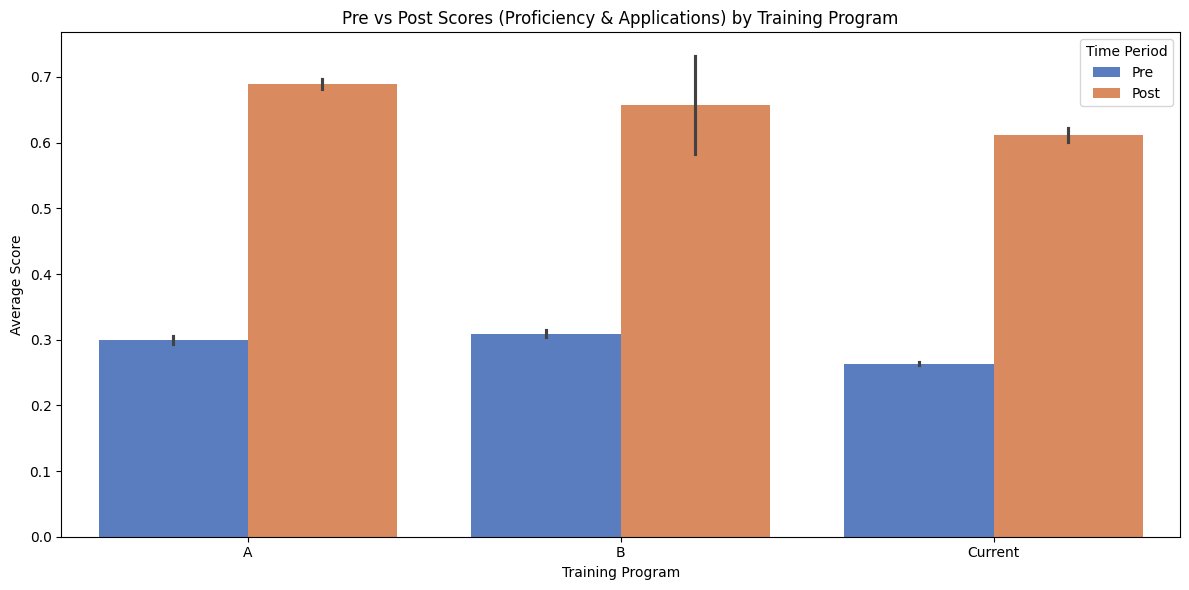

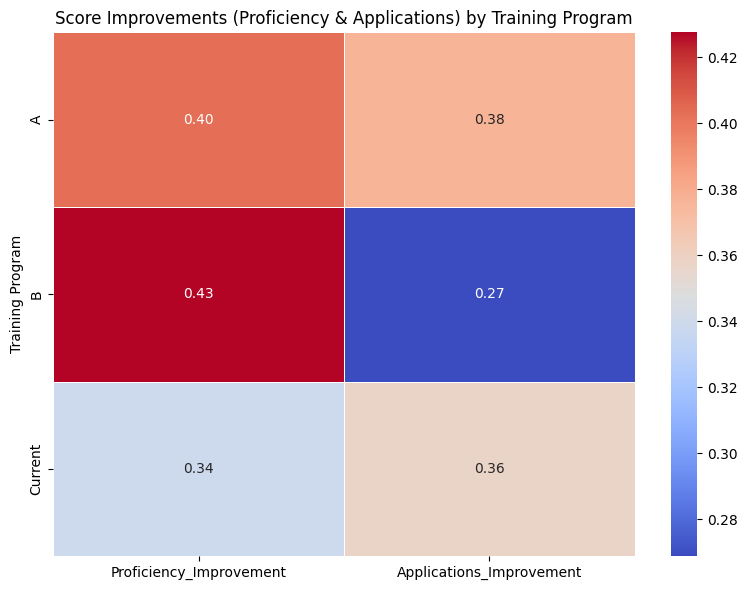

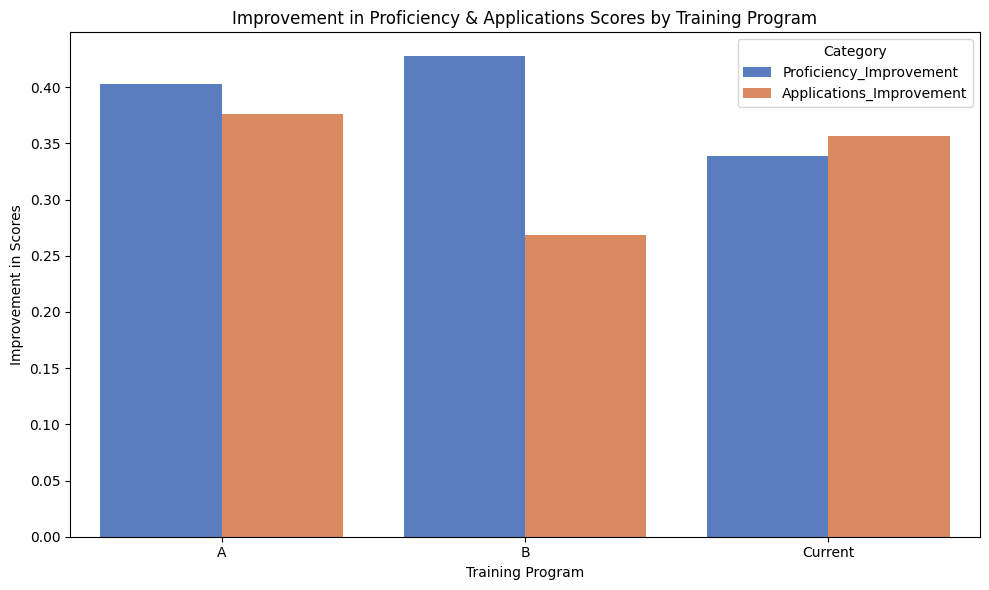

In [23]:

# Grouped data for plotting
grouped_data = data.groupby('Training_Program').agg({
    'Intake_Proficiency_Score': 'mean',
    'Outcome_Proficiency_Score': 'mean',
    'Intake_Applications_Score': 'mean',
    'Outcome_Applications_Score': 'mean'
}).reset_index()

# Melt data for combined plotting
melted_combined = pd.melt(grouped_data, id_vars='Training_Program', 
                          value_vars=['Intake_Proficiency_Score', 'Outcome_Proficiency_Score',
                                      'Intake_Applications_Score', 'Outcome_Applications_Score'],
                          var_name='Metric', value_name='Score')

# Add Metric Categories
melted_combined['Category'] = melted_combined['Metric'].apply(
    lambda x: 'Proficiency' if 'Proficiency' in x else 'Applications'
)
melted_combined['Time Period'] = melted_combined['Metric'].apply(
    lambda x: 'Pre' if 'Intake' in x else 'Post'
)

# 1. Combined Bar Plot: Proficiency and Applications Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_combined, x='Training_Program', y='Score', hue='Time Period', palette='muted')
plt.title('Pre vs Post Scores (Proficiency & Applications) by Training Program')
plt.ylabel('Average Score')
plt.xlabel('Training Program')
plt.legend(title='Time Period')
plt.tight_layout()
plt.show()

# 2. Heatmap for Improvements in Scores
improvement_data = grouped_data.copy()
improvement_data['Proficiency_Improvement'] = improvement_data['Outcome_Proficiency_Score'] - improvement_data['Intake_Proficiency_Score']
improvement_data['Applications_Improvement'] = improvement_data['Outcome_Applications_Score'] - improvement_data['Intake_Applications_Score']
improvement_heatmap = improvement_data[['Training_Program', 'Proficiency_Improvement', 'Applications_Improvement']].set_index('Training_Program')

plt.figure(figsize=(8, 6))
sns.heatmap(improvement_heatmap, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Score Improvements (Proficiency & Applications) by Training Program')
plt.ylabel('Training Program')
plt.tight_layout()
plt.show()

# 3. Stacked Bar Plot: Combined Improvements
improvement_stacked = improvement_data[['Training_Program', 'Proficiency_Improvement', 'Applications_Improvement']].melt(
    id_vars='Training_Program', var_name='Category', value_name='Improvement'
)

plt.figure(figsize=(10, 6))
sns.barplot(data=improvement_stacked, x='Training_Program', y='Improvement', hue='Category', palette='muted')
plt.title('Improvement in Proficiency & Applications Scores by Training Program')
plt.ylabel('Improvement in Scores')
plt.xlabel('Training Program')
plt.legend(title='Category')
plt.tight_layout()
plt.show()


Summary of Pre- and Post-Scores by Training Program:

                  Pre_Proficiency_Score  Post_Proficiency_Score  \
Training_Program                                                  
A                              0.334652                0.716650   
B                              0.333260                0.765597   
Current                        0.255546                0.626615   

                  Pre_Applications_Score  Post_Applications_Score  
Training_Program                                                   
A                               0.344651                 0.712273  
B                               0.349542                 0.591432  
Current                         0.276114                 0.653896  

Crosstab Summary for Curriculum A:

Post       After
treatA          
0       0.678495
1       0.716650

Crosstab Summary for Curriculum B:

Post       After
treatB          
0       0.658634
1       0.765597

Difference-in-Differences Results for Curriculum A:

      

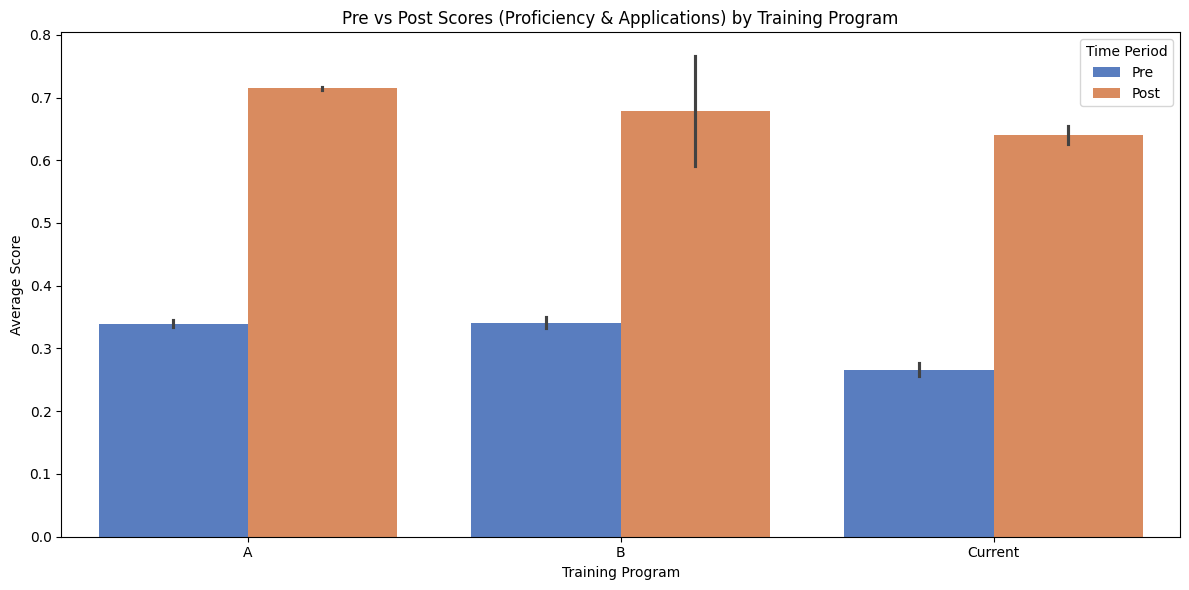

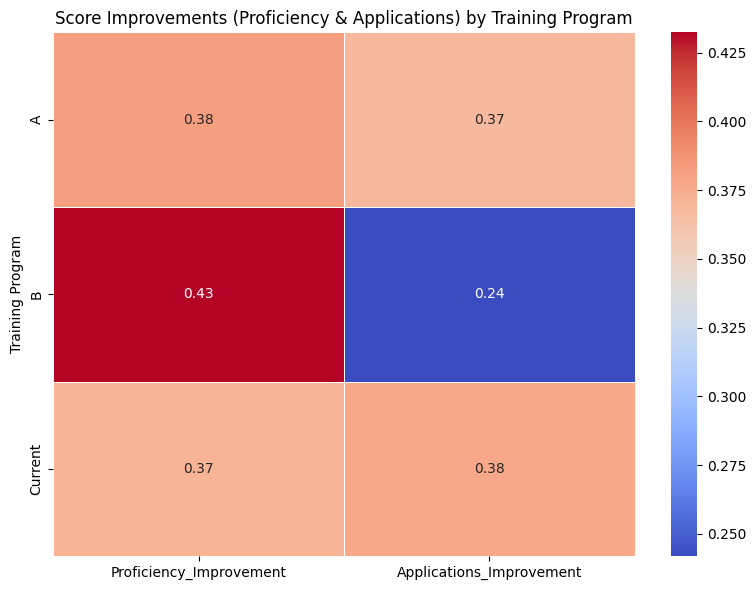

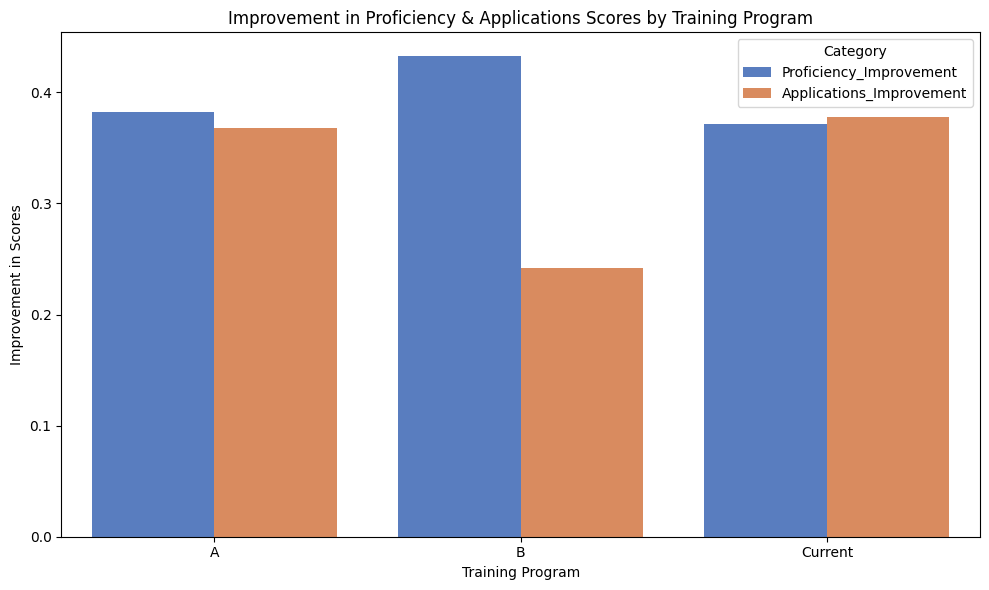

In [26]:
# The Below Code filters the Analysis to 3 Cities only  (Los Angeles, Denver, Houston)


# Filter the dataset for the selected cities (Los Angeles, Denver, Houston)
selected_cities = ['Los Angeles', 'Denver', 'Houston']
data = data[data['City'].isin(selected_cities)]

# Add pre/post indicator
data['Post'] = data['Outcome_Proficiency_Score'] > data['Intake_Proficiency_Score']

# Create treatment indicators for Curricula A and B
data['treatA'] = data['Training_Program'].apply(lambda x: 1 if x == 'A' else 0)
data['treatB'] = data['Training_Program'].apply(lambda x: 1 if x == 'B' else 0)

# Summarize scores for each program pre- and post-intervention
summary = data.groupby('Training_Program').agg({
    'Intake_Proficiency_Score': 'mean',
    'Outcome_Proficiency_Score': 'mean',
    'Intake_Applications_Score': 'mean',
    'Outcome_Applications_Score': 'mean'
}).rename(columns={
    'Intake_Proficiency_Score': 'Pre_Proficiency_Score',
    'Outcome_Proficiency_Score': 'Post_Proficiency_Score',
    'Intake_Applications_Score': 'Pre_Applications_Score',
    'Outcome_Applications_Score': 'Post_Applications_Score'
})
print("Summary of Pre- and Post-Scores by Training Program:\n")
print(summary)

# Crosstab for Curriculum A (treated vs untreated, pre and post)
crosstab_treatA = pd.crosstab(
    index=data['treatA'],
    columns=data['Post'],
    values=data['Outcome_Proficiency_Score'],
    aggfunc='mean'
).rename(columns={0: 'Before', 1: 'After'})

# Crosstab for Curriculum B
crosstab_treatB = pd.crosstab(
    index=data['treatB'],
    columns=data['Post'],
    values=data['Outcome_Proficiency_Score'],
    aggfunc='mean'
).rename(columns={0: 'Before', 1: 'After'})

# Print Crosstab summaries
print("\nCrosstab Summary for Curriculum A:\n")
print(crosstab_treatA)

print("\nCrosstab Summary for Curriculum B:\n")
print(crosstab_treatB)

# Run Difference-in-Differences Regression for Proficiency Scores
model_A = smf.ols(
    formula='Outcome_Proficiency_Score ~ treatA * Post',
    data=data
).fit()

model_B = smf.ols(
    formula='Outcome_Proficiency_Score ~ treatB * Post',
    data=data
).fit()

# Print model summaries
print("\nDifference-in-Differences Results for Curriculum A:\n")
print(model_A.summary())

print("\nDifference-in-Differences Results for Curriculum B:\n")
print(model_B.summary())

# Grouped data for plotting
grouped_data = data.groupby('Training_Program').agg({
    'Intake_Proficiency_Score': 'mean',
    'Outcome_Proficiency_Score': 'mean',
    'Intake_Applications_Score': 'mean',
    'Outcome_Applications_Score': 'mean'
}).reset_index()

# Melt data for combined plotting
melted_combined = pd.melt(grouped_data, id_vars='Training_Program', 
                          value_vars=['Intake_Proficiency_Score', 'Outcome_Proficiency_Score',
                                      'Intake_Applications_Score', 'Outcome_Applications_Score'],
                          var_name='Metric', value_name='Score')

# Add Metric Categories
melted_combined['Category'] = melted_combined['Metric'].apply(
    lambda x: 'Proficiency' if 'Proficiency' in x else 'Applications'
)
melted_combined['Time Period'] = melted_combined['Metric'].apply(
    lambda x: 'Pre' if 'Intake' in x else 'Post'
)

# 1. Combined Bar Plot: Proficiency and Applications Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_combined, x='Training_Program', y='Score', hue='Time Period', palette='muted')
plt.title('Pre vs Post Scores (Proficiency & Applications) by Training Program')
plt.ylabel('Average Score')
plt.xlabel('Training Program')
plt.legend(title='Time Period')
plt.tight_layout()
plt.show()

# 2. Heatmap for Improvements in Scores
improvement_data = grouped_data.copy()
improvement_data['Proficiency_Improvement'] = improvement_data['Outcome_Proficiency_Score'] - improvement_data['Intake_Proficiency_Score']
improvement_data['Applications_Improvement'] = improvement_data['Outcome_Applications_Score'] - improvement_data['Intake_Applications_Score']
improvement_heatmap = improvement_data[['Training_Program', 'Proficiency_Improvement', 'Applications_Improvement']].set_index('Training_Program')

plt.figure(figsize=(8, 6))
sns.heatmap(improvement_heatmap, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Score Improvements (Proficiency & Applications) by Training Program')
plt.ylabel('Training Program')
plt.tight_layout()
plt.show()

# 3. Stacked Bar Plot: Combined Improvements
improvement_stacked = improvement_data[['Training_Program', 'Proficiency_Improvement', 'Applications_Improvement']].melt(
    id_vars='Training_Program', var_name='Category', value_name='Improvement'
)

plt.figure(figsize=(10, 6))
sns.barplot(data=improvement_stacked, x='Training_Program', y='Improvement', hue='Category', palette='muted')
plt.title('Improvement in Proficiency & Applications Scores by Training Program')
plt.ylabel('Improvement in Scores')
plt.xlabel('Training Program')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

